In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random


/var/folders/v9/wq9d9w3501v5y6219s4smvyw0000gn/T/ipykernel_7130/2445178329.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#set seed for everything
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#训练方案分析
原模型是在sn>1的样本上进行finetune训练的。

但是对于sn较差的样本没有理会，
- 应该在这些样本上进行semi-supervise。
- 最后在真实样本上再进行退火处理。

# Get data and do some data processing

# Get pytorch dataset

In [32]:
from torch.utils.data import Dataset, DataLoader
from ast import literal_eval


from Network import *
import yaml



class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config, pretrained=False):
        super(finetuned_RibonanzaNet, self).__init__(config)
        if pretrained:
            self.load_state_dict(torch.load("/kaggle/input/ribonanzanet-weights/RibonanzaNet.pt",map_location='cpu'))
        self.decoder=nn.Linear(256,5)

    def forward(self,src):
        
        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))
        output=self.decoder(sequence_features)

        return output.squeeze(-1)
    

class RNA_test_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

class RNA_Dataset(Dataset):
    def __init__(self,data, length=68):
        self.data=data
        self.length=length
        self.tokens={nt:i for i,nt in enumerate('ACGU')}
        self.label_names=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
               
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in (self.data.loc[idx,'sequence'])]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)
        
        labels=np.stack([self.data.loc[idx,l] for l in self.label_names],-1)
        labels=torch.tensor(labels)
        if len(labels)>self.length:
            labels=labels[:self.length]
        return {'sequence':sequence,
                'labels':labels}

In [4]:
config=load_config_from_yaml("configs/pairwise.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device= torch.device("mps")
model=finetuned_RibonanzaNet(config,pretrained=False).to(device)
#1. Initial Model Training-only confident labels:
model.load_state_dict(torch.load("../ribonanzanet-weights/RibonanzaNet-Deg.pt",map_location=device))

constructing 9 ConvTransformerEncoderLayers


<All keys matched successfully>

In [12]:
data=pd.read_json("train_pseudo.json",lines=True).reset_index(drop=True)
data_noisy = data.loc[data['signal_to_noise']<=1].reset_index(drop=True)
data=data.loc[data['signal_to_noise']>1].reset_index(drop=True)

Text(0.5, 0, 'signal_to_noise')

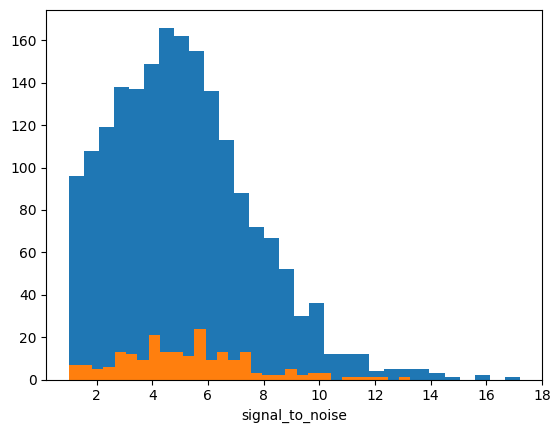

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold
data['length']=data['sequence'].apply(len)
kf = StratifiedKFold(n_splits=10,random_state=2020, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(data,data['SN_filter'])):
    break

train_split=data.loc[train_index].reset_index(drop=True)
val_split=data.loc[val_index].reset_index(drop=True)
val_split=val_split.loc[val_split['signal_to_noise']>1].reset_index(drop=True)

plt.hist(train_split['signal_to_noise'],bins=30)
plt.hist(val_split['signal_to_noise'],bins=30)
plt.xlabel('signal_to_noise')

# copy pseudo label for noisy data

In [17]:
data_noisy.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'pseudo_reactivity',
       'pseudo_deg_Mg_pH10', 'pseudo_deg_pH10', 'pseudo_deg_Mg_50C',
       'pseudo_deg_50C'],
      dtype='object')

In [19]:
data_noisy[['reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C']] = data_noisy[['pseudo_reactivity',
       'pseudo_deg_Mg_pH10', 'pseudo_deg_pH10', 'pseudo_deg_Mg_50C',
       'pseudo_deg_50C']]

train_step2=pd.concat([train_split,data_noisy],axis=0).reset_index(drop=True)
train_step2

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,pseudo_reactivity,pseudo_deg_Mg_pH10,pseudo_deg_pH10,pseudo_deg_Mg_50C,pseudo_deg_50C,length
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.34715089200000004, 1.5796933174, 1.12351059...","[0.6049603224, 2.9363353252, 0.2550430596, 1.2...","[2.6121025085, 3.5633585453, 0.3173390031, 0.9...","[0.4698945284, 3.3145470619, 0.2526535988, 1.6...","[0.7628977299, 3.3258330822, 0.772382319000000...",107.0
1,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.49438652400000005, 1.359932065, 1.182132720...","[0.5494311452, 1.5888272524, 0.781946122600000...","[2.2362072468, 3.0743534565, 1.0018054247, 0.6...","[0.45601245760000003, 1.6323196888, 1.20958185...","[0.7719741464000001, 1.9179110527, 1.328220725...",107.0
2,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...",...,"[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0...","[0.6539532542000001, 1.4050060511, 1.247644543...","[0.6421555877, 1.8779562712, 1.0152028799, 0.4...","[1.8762878180000002, 2.0765528679, 0.995284974...","[0.5660399199, 1.8662604094000002, 1.373308181...","[0.6225880384, 1.4055548906, 1.0492841005, 0.5...",107.0
3,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...",...,"[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1...","[0.8853771091, 2.7671675682, 2.3205535412, 2.0...","[0.7543846965000001, 3.7027943134, 1.264313221...","[2.6179661751000003, 6.0851788521, 1.865887761...","[0.6917392015, 3.4733273983, 1.4873697758, 1.3...","[0.9122445583000001, 3.384480238, 1.3320858479...",107.0
4,9,id_010ab0472,GGAAAGCAUGGGACCACGAUUCACAUCGGUCUGCACGUAGGACAUU...,.....(((...((((..(((....))))))))))(((((((((......,EEEEESSSBBBSSSSBBSSSHHHHSSSSSSSSSSSSSSSSSSSIII...,5.545,1,107,68,"[0.1754, 0.1784, 0.1526, 0.1331, 0.13720000000...",...,"[0.6237, 1.0674, 1.2511, 0.30560000000000004, ...","[1.8982, 2.2653, 1.5584, 0.7352000000000001, 0...","[0.23140000000000002, 1.1193, 1.103, 0.5249, 0...","[1.0121, 2.0629, 1.3669, 0.9423, 0.88040000000...","[0.3939593136, 0.7397066951, 0.9841383696, 0.5...","[0.5187180638000001, 1.2671017647, 0.920283854...","[2.1809523106, 2.4730124474, 1.2828187943, 0.5...","[0.4119487107, 1.1664626598, 1.2020825148, 0.6...","[0.640965879, 1.6035062075000002, 1.2896068096...",107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2362,id_fbd5a6bb5,GGAAAGACGCCUGGCCGAGGCGGAGCGGCCGGCCGACGAGAGGAGG...,.......(((((((((...((...))((

In [20]:
highSN=train_step2.loc[train_step2['signal_to_noise']>5].reset_index(drop=True)
highSN

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,pseudo_reactivity,pseudo_deg_Mg_pH10,pseudo_deg_pH10,pseudo_deg_Mg_50C,pseudo_deg_50C,length
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.34715089200000004, 1.5796933174, 1.12351059...","[0.6049603224, 2.9363353252, 0.2550430596, 1.2...","[2.6121025085, 3.5633585453, 0.3173390031, 0.9...","[0.4698945284, 3.3145470619, 0.2526535988, 1.6...","[0.7628977299, 3.3258330822, 0.772382319000000...",107.0
1,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.49438652400000005, 1.359932065, 1.182132720...","[0.5494311452, 1.5888272524, 0.781946122600000...","[2.2362072468, 3.0743534565, 1.0018054247, 0.6...","[0.45601245760000003, 1.6323196888, 1.20958185...","[0.7719741464000001, 1.9179110527, 1.328220725...",107.0
2,9,id_010ab0472,GGAAAGCAUGGGACCACGAUUCACAUCGGUCUGCACGUAGGACAUU...,.....(((...((((..(((....))))))))))(((((((((......,EEEEESSSBBBSSSSBBSSSHHHHSSSSSSSSSSSSSSSSSSSIII...,5.545,1,107,68,"[0.1754, 0.1784, 0.1526, 0.1331, 0.13720000000...",...,"[0.6237, 1.0674, 1.2511, 0.30560000000000004, ...","[1.8982, 2.2653, 1.5584, 0.7352000000000001, 0...","[0.23140000000000002, 1.1193, 1.103, 0.5249, 0...","[1.0121, 2.0629, 1.3669, 0.9423, 0.88040000000...","[0.3939593136, 0.7397066951, 0.9841383696, 0.5...","[0.5187180638000001, 1.2671017647, 0.920283854...","[2.1809523106, 2.4730124474, 1.2828187943, 0.5...","[0.4119487107, 1.1664626598, 1.2020825148, 0.6...","[0.640965879, 1.6035062075000002, 1.2896068096...",107.0
3,10,id_0172c2cb6,GGAAAAUGCGAUCUAGGUAUAUAAGGAUGUUGUAGAAGAUCUUAUA...,.......(((.(((((((((((..(((((((((((......)))))...,EEEEEEESSSBSSSSSSSSSSSBBSSSSSSSSSSSHHHHHHSSSSS...,5.934,1,107,68,"[0.1612, 0.1985, 0.1557, 0.11270000000000001, ...",...,"[1.0153, 2.6253, 0.8534, 0.3032, 1.0661, 1.126...","[2.5968999999999998, 4.1737, 1.0042, 0.3202000...","[0.5901000000000001, 3.3422, 1.3103, 0.2729000...","[0.7395, 3.2518000000000002, 1.1306, 0.4777, 1...","[0.6549244523000001, 1.8618059158, 0.995630085...","[0.8233569264, 2.7822380066, 0.825156748300000...","[2.7171478271, 4.2157297134, 1.1032375097, 0.3...","[0.6204099655, 3.490240097, 1.379308939, 0.340...","[0.9519925117, 3.3957703114, 1.2590910196, 0.4...",107.0
4,11,id_0197d5afb,GGAAAGCGAUCACGAAAACCGAAACGAGAAACAUGAAACAAGUAAC...,.....((((.(.(((...(((...((((..((.((...)).))..)...,EEEEESSSSISISSSIIISSSIIISSSSIISSISSHHHSSISSIIS...,9.540,1,107,68,"[0.109, 0.13720000000000002, 0.128400000000000...",...,"[0.889, 2.1651, 1.1683, 0.7428, 0.4701, 0.2363...","[1.9673, 2.9951, 1.3573, 1.1557, 0.68780000000...","[0.73, 2.045, 1.7421, 1.0795, 0.3972, 0.1489, ...","[0.9172, 2.0825, 1.6199, 1.0091, 0.8051, 0.223...","[0.7131134868, 1.8935495615, 1.5325232744, 0.9...","[1.0514235497, 2.0816664696, 1.0307605267, 0.6...","[2.1874666214, 2.9944462776, 1.4379746914, 0.9...","[0.7964622378, 2.0651044846, 1.5697842836, 0.9...","[0.8278126717000001, 2.2268886566, 1.552367806...",107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,2384,id_fe1d9a133,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((..

In [33]:
train_loader2=DataLoader(RNA_Dataset(train_step2),batch_size=32,shuffle=True)
highSN_loader=DataLoader(RNA_Dataset(highSN),batch_size=32,shuffle=True)
val_loader = DataLoader(RNA_Dataset(val_split),batch_size=32,shuffle=False)

In [39]:
from ranger import Ranger
from tqdm import tqdm
#loss function
def MCRMAE(y_pred, y_true):
    # 计算每列的MAE
    colwise_mae = torch.mean(torch.abs(y_true - y_pred), dim=0)
    # 计算列MAE的均值
    MCRMAE = torch.mean(colwise_mae)
    return MCRMAE

epochs=20
cos_epoch=15

best_loss=np.inf
optimizer = Ranger(model.parameters(), lr=0.001)


criterion=MCRMAE
lr = 0.001
# schedule=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(epochs-cos_epoch)*len(train_loader))


for epoch in range(epochs):
    model.train()
    tbar=tqdm(train_loader2)
    total_loss=0
    oom=0
    for idx, batch in enumerate(tbar):
        sequence=batch['sequence'].to(device)
        labels=batch['labels'].float().to(device)

        output=model(sequence)

        loss=criterion(output[:,:68],labels)
        loss=loss.mean()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        optimizer.zero_grad()

#         if (epoch+1)>cos_epoch:
#             schedule.step()
        #schedule.step()
        total_loss+=loss.item()

        tbar.set_description(f"Epoch {epoch + 1} Loss: {total_loss/(idx+1)}")
        #break

    tbar=tqdm(val_loader)
    model.eval()
    val_preds=[]
    val_loss=0
    for idx, batch in enumerate(tbar):
        sequence=batch['sequence'].to(device)
        labels=batch['labels'].float().to(device)

        with torch.no_grad():
            output=model(sequence)
            
            loss=criterion(output[:,:68],labels)
            loss=loss.mean()
        val_loss+=loss.item()
        val_preds.append([labels.cpu().numpy(),output.cpu().numpy()])
    val_loss=val_loss/len(tbar)
    print(f"val loss: {val_loss}")
    if val_loss<best_loss:
        best_loss=val_loss
        best_preds=val_preds
        torch.save(model.state_dict(),'RibonanzaNet-Deg_20.pt')

    # 1.053595052265986 train loss after epoch 0

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


  0%|          | 0/69 [00:00<?, ?it/s]/Users/lihongmin/mambaforge/envs/torch/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/lihongmin/Research/ideas/RibonanzaNet/Ranger-Deep-Learning-Optimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1630.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2

In [ ]:
from ranger import Ranger
from tqdm import tqdm
#loss function
def MCRMAE(y_pred, y_true):
    # 计算每列的MAE
    colwise_mae = torch.mean(torch.abs(y_true - y_pred), dim=0)
    # 计算列MAE的均值
    MCRMAE = torch.mean(colwise_mae)
    return MCRMAE

epochs=10
cos_epoch=7

best_loss=np.inf
optimizer = Ranger(model.parameters(), weight_decay=0.001, lr=0.001)


criterion=MCRMAE
lr = 0.001
schedule=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(epochs-cos_epoch)*len(highSN_loader))


for epoch in range(epochs):
    model.train()
    tbar=tqdm(highSN_loader)
    total_loss=0
    oom=0
    for idx, batch in enumerate(tbar):
        sequence=batch['sequence'].to(device)
        labels=batch['labels'].float().to(device)

        output=model(sequence)

        loss=criterion(output[:,:68],labels)
        loss=loss.mean()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        optimizer.zero_grad()

        if (epoch+1)>cos_epoch:
            schedule.step()
        total_loss+=loss.item()

        tbar.set_description(f"Epoch {epoch + 1} Loss: {total_loss/(idx+1)}")
        #break

    tbar=tqdm(val_loader)
    model.eval()
    val_preds=[]
    val_loss=0
    for idx, batch in enumerate(tbar):
        sequence=batch['sequence'].to(device)
        labels=batch['labels'].float().to(device)

        with torch.no_grad():
            output=model(sequence)
            
            loss=criterion(output[:,:68],labels)
            loss=loss.mean()
        val_loss+=loss.item()
        val_preds.append([labels.cpu().numpy(),output.cpu().numpy()])
    val_loss=val_loss/len(tbar)
    print(f"val loss: {val_loss}")
    if val_loss<best_loss:
        best_loss=val_loss
        best_preds=val_preds
        torch.save(model.state_dict(),'RibonanzaNet-Deg_21.pt')

    # 1.053595052265986 train loss after epoch 0